In [1]:
import gc
import os
import random
import re
import statistics as st
import warnings
from collections import Counter

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from scipy.stats import kurtosis, skew
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 5
    num_estimators = 10000
    num_trials_early_stopping = 100

    response_variate = "score"
    use_optuna_tuning = False
    test_size_optuna = 0.3
    num_trials_optuna = 150

    num_features_to_display = 50

In [3]:
cnfg = Config()

In [4]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)

In [5]:
train_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")
test_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [6]:
train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

### Utils ###

In [7]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst)
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x

### Pre-processing ###

In [8]:
class Preprocessor:
    def __init__(self, seed, df):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["up_time"] - self.df.groupby("id").down_time.shift(1)
        self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(1)
        self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(1)
        self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )

            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ].fillna(-1)

        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )

            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ].fillna(-1)

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            my_kurtosis,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                tmp_df[colname_method] = tmp_df[colname_method].fillna(0)

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )

            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )

        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")
        tmp_df["total_remove_activity"] = tmp_df["total_remove_activity"].fillna(0)

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )

        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")
        tmp_df["total_replace_activity"] = tmp_df["total_replace_activity"].fillna(0)

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")
        tmp_df["total_np_activity"] = tmp_df["total_np_activity"].fillna(0)

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)

        return tmp_df

    def get_stats_for_different_latency(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            my_kurtosis,
            my_median_grouped,
        ]
        clms_for_stats = ["action_time", "IL", "PL"]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_latency(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        feats = feats.drop(columns=features_to_drop)
        return feats

    def pre_process_data(self):
        self.clean_data()

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()

        return self.df, features_df

In [9]:
preprocess_train = Preprocessor(cnfg.seed, train_logs)
train_logs2, train_feats = preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
preprocess_test = Preprocessor(cnfg.seed, test_logs)
_, test_feats = preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (8405898, 11)
After uptime cleaning, data shape: (8405898, 11)
-------------------------
Starting Activity Features


2471it [00:00, 10299.36it/s]


Features dropping in activity function []
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 33063.95it/s]



-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (6, 11)
After uptime cleaning, data shape: (6, 11)
-------------------------
Starting Activity Features


3it [00:00, 38014.84it/s]


Features dropping in activity function []
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]


In [10]:
train_logs2

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,IL,PL,RL
0,001519c8,1,4.526,4.557,0.031,Nonproduction,Leftclick,Leftclick,NoChange,0,0,0.000,0.000,0.000
1,001519c8,2,4.558,4.962,0.404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,0.436,0.032,0.405
2,001519c8,3,106.571,106.571,0.000,Nonproduction,Shift,Shift,NoChange,0,0,102.013,102.013,101.609
3,001519c8,4,106.686,106.777,0.091,Input,q,q,q,1,1,0.206,0.115,0.206
4,001519c8,5,107.196,107.323,0.127,Input,q,q,q,2,1,0.637,0.510,0.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063.944,2064.440,0.496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240,2.023,1.527,1.885
8405894,fff05981,3616,2064.497,2064.497,0.000,Nonproduction,Shift,Shift,NoChange,1031,240,0.553,0.553,0.057
8405895,fff05981,3617,2064.657,2064.765,0.108,Replace,q,q,q => q,1031,240,0.268,0.160,0.268
8405896,fff05981,3618,2069.186,2069.259,0.073,Nonproduction,Leftclick,Leftclick,NoChange,1028,240,4.602,4.529,4.494


In [11]:
train_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [12]:
# tmp = train_logs2.groupby(["id"]).agg({'PL': my_std}).reset_index().rename(columns={'PL': 'min_PL'})

In [13]:
# tmp.min_PL.describe()

In [14]:
train_feats.head()

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_2_share,words_of_len_3_share,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share
0,001519c8,1797.351,2094.432,255,1539,2557,5,1.422649,0.141875,0.099726,...,76,54,49,43,29,30,15,21,10,31
1,0022f953,1758.219,2033.053,320,1676,2454,5,1.395731,0.182002,0.130399,...,71,98,69,45,37,13,8,6,6,17
2,0042269b,1766.778,2186.390,404,2291,4136,4,2.340985,0.228665,0.097679,...,98,109,102,70,48,54,34,31,13,58
3,0059420b,1362.999,1552.444,206,1047,1556,5,1.141600,0.151137,0.132391,...,51,37,50,27,24,25,4,4,3,13
4,0075873a,1583.920,1897.356,252,1402,2531,3,1.597934,0.159099,0.099565,...,69,75,72,47,33,16,20,16,13,25


In [15]:
# train_logs2['IL']

In [16]:
train_feats.IL_stats_my_median_grouped.describe()

count    2471.000000
mean        0.259707
std         0.297508
min        -0.388464
25%         0.015487
50%         0.262545
75%         0.510476
max         0.970000
Name: IL_stats_my_median_grouped, dtype: float64

In [17]:
train_feats[train_feats.isna().any(axis=1)]

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_2_share,words_of_len_3_share,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share


In [18]:
train_feats.columns[train_feats.isnull().any()].tolist()

[]

In [19]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [20]:
test_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_2_share,words_of_len_3_share,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share
0,0000aaaa,421.640,421.727,0,1,2,1,0.004743,0.00000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2222bbbb,-421.454,-421.408,0,1,2,1,-0.004745,-0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4444cccc,-450.551,-450.495,1,1,2,1,-0.004439,-0.00222,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# clms_with_na = features_df.columns[features_df.isnull().any()].tolist()

In [22]:
# for clm in clms_with_na:
#     # print(f"{clm}\n")
#     print(features_df[f"{clm}"].isna().value_counts())
#     print("\n")

In [23]:
train_feats.columns.tolist()

['id',
 'total_time_taken',
 'total_idle_time',
 'total_word_count',
 'max_cursor_position',
 'num_events',
 'total_type_of_activities',
 'speed_of_activity',
 'speed_of_writing',
 'events_per_word',
 'idle_time_ratio',
 'words_to_cp_ratio',
 'activity_input_count',
 'activity_remove_count',
 'activity_non_production_count',
 'activity_replace_count',
 'activity_paste_count',
 'input_first_time',
 'remove_first_time',
 'non_production_first_time',
 'replace_first_time',
 'paste_first_time',
 'input_last_time',
 'remove_last_time',
 'non_production_last_time',
 'replace_last_time',
 'paste_last_time',
 'input_my_min_inter_act_latency',
 'input_my_max_inter_act_latency',
 'input_my_mean_inter_act_latency',
 'input_my_std_inter_act_latency',
 'input_my_skew_inter_act_latency',
 'input_my_kurtosis_inter_act_latency',
 'input_my_median_grouped_inter_act_latency',
 'remove_my_min_inter_act_latency',
 'remove_my_max_inter_act_latency',
 'remove_my_mean_inter_act_latency',
 'remove_my_std_inte

In [24]:
train_feats.equal_to_in_input_tc_total_share.describe()

count    2471.000000
mean        0.462161
std         1.507365
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        33.000000
Name: equal_to_in_input_tc_total_share, dtype: float64

In [25]:
# features_df.square_bracket_open_in_input_share.value_counts()

In [26]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [27]:
print(f"Shape of training data: {train_feats.shape}")
print(f"Shape of test data: {test_feats.shape}")

Shape of training data: (2471, 185)
Shape of test data: (3, 184)


In [28]:
train_feats.columns[train_feats.isna().any()]

Index([], dtype='object')

# Split Train Data Into Folds For Cross-Validation

In [29]:
# kfold = KFold(n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed)

kfold = StratifiedKFold(n_splits=cnfg.num_folds, shuffle=True, random_state=cnfg.seed)
for fold, (_, val_idx) in enumerate(
    kfold.split(train_feats, train_feats.score.apply(str).values)
):
    train_feats.loc[val_idx, "fold"] = fold

# Optimizing Hyperparameters with Optuna

In [30]:
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    print(trial.number)
    param = {
        "metric": "rmse",
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "verbose": -1,
        "early_stopping_rounds": cnfg.num_trials_early_stopping,
    }

    feature_names = list(
        filter(
            lambda x: x not in [cnfg.response_variate, "id", "fold"],
            train_feats_df.columns,
        )
    )

    # models_dict = {}

    for fold in range(cnfg.num_folds):
        # print(f"Training for FOLD {fold}")

        X_train = train_feats_df[train_feats_df["fold"] != fold][feature_names]
        Y_train = train_feats_df[train_feats_df["fold"] != fold][cnfg.response_variate]

        X_val = train_feats_df[train_feats_df["fold"] == fold][feature_names]
        Y_val = train_feats_df[train_feats_df["fold"] == fold][cnfg.response_variate]

        model = lgb.LGBMRegressor(**param)

        model.fit(
            X_train,
            Y_train,
            eval_names=["train", "valid"],
            eval_set=[(X_train, Y_train), (X_val, Y_val)],
            # verbose=-1,
            eval_metric="rmse",
            # early_stopping_rounds=cnfg.num_trials_early_stopping,
        )

        # models_dict[fold] = model

        pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
        train_feats_df.loc[X_val.index, f"pred_{cnfg.response_variate}"] = pred_val

    rmse = mean_squared_error(
        train_feats_df[cnfg.response_variate],
        np.clip(train_feats_df[f"pred_{cnfg.response_variate}"], a_min=0.5, a_max=6.0),
        squared=False,
    )

    return rmse

In [31]:
if cnfg.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
    )

[I 2023-10-30 22:40:22,872] A new study created in memory with name: Optimize boosting hyperparameters


0


[I 2023-10-30 22:40:58,258] Trial 0 finished with value: 0.6325943937121048 and parameters: {'reg_alpha': 0.009946296846626483, 'reg_lambda': 8.099429835794432, 'colsample_bytree': 0.6004647132293043, 'subsample': 0.8028745088969141, 'learning_rate': 0.0008392564230935138, 'num_leaves': 21, 'min_child_samples': 55}. Best is trial 0 with value: 0.6325943937121048.


1


[I 2023-10-30 22:41:00,062] Trial 1 finished with value: 0.6416574970800195 and parameters: {'reg_alpha': 0.6561080258384974, 'reg_lambda': 0.25391695834308053, 'colsample_bytree': 0.6228179816808626, 'subsample': 0.7780184855604133, 'learning_rate': 0.02390452641062019, 'num_leaves': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.6325943937121048.


2


[I 2023-10-30 22:41:54,927] Trial 2 finished with value: 0.68008619847451 and parameters: {'reg_alpha': 0.0684001686291156, 'reg_lambda': 0.00549846415557213, 'colsample_bytree': 0.5031577124125431, 'subsample': 0.6161092536882156, 'learning_rate': 0.00014906281962750523, 'num_leaves': 26, 'min_child_samples': 41}. Best is trial 0 with value: 0.6325943937121048.


3


[I 2023-10-30 22:41:56,245] Trial 3 finished with value: 0.6394273908904221 and parameters: {'reg_alpha': 0.015365213905248523, 'reg_lambda': 0.03953331619488674, 'colsample_bytree': 0.9248784788175959, 'subsample': 0.8008929232928397, 'learning_rate': 0.07495559392295927, 'num_leaves': 23, 'min_child_samples': 70}. Best is trial 0 with value: 0.6325943937121048.


4


[I 2023-10-30 22:41:57,453] Trial 4 finished with value: 0.6430799418142467 and parameters: {'reg_alpha': 0.0017984673132919878, 'reg_lambda': 0.23162701136252078, 'colsample_bytree': 0.5839982247302978, 'subsample': 0.7104440372343603, 'learning_rate': 0.08928691779781106, 'num_leaves': 26, 'min_child_samples': 14}. Best is trial 0 with value: 0.6325943937121048.


5


[I 2023-10-30 22:42:25,661] Trial 5 finished with value: 0.6358256487957803 and parameters: {'reg_alpha': 0.03480483768120533, 'reg_lambda': 0.02156881171943615, 'colsample_bytree': 0.8769549486852617, 'subsample': 0.7584351093521701, 'learning_rate': 0.0009701509476245354, 'num_leaves': 16, 'min_child_samples': 42}. Best is trial 0 with value: 0.6325943937121048.


6


[I 2023-10-30 22:42:27,094] Trial 6 finished with value: 0.6355116210044585 and parameters: {'reg_alpha': 0.002591109529120746, 'reg_lambda': 0.016328232811862395, 'colsample_bytree': 0.7819233433602575, 'subsample': 0.7508797868174667, 'learning_rate': 0.024431775914569562, 'num_leaves': 10, 'min_child_samples': 67}. Best is trial 0 with value: 0.6325943937121048.


7


[I 2023-10-30 22:43:25,170] Trial 7 finished with value: 0.6887372548282609 and parameters: {'reg_alpha': 4.328422896838847, 'reg_lambda': 0.16977448520146213, 'colsample_bytree': 0.8147313486381909, 'subsample': 0.5310893292743262, 'learning_rate': 0.00014858213794993717, 'num_leaves': 28, 'min_child_samples': 17}. Best is trial 0 with value: 0.6325943937121048.


8


[I 2023-10-30 22:43:39,662] Trial 8 finished with value: 0.6347876863545701 and parameters: {'reg_alpha': 1.8180494734127772, 'reg_lambda': 2.3879760568815036, 'colsample_bytree': 0.6161814025323238, 'subsample': 0.8393504837478751, 'learning_rate': 0.0023353871748613636, 'num_leaves': 20, 'min_child_samples': 31}. Best is trial 0 with value: 0.6325943937121048.


9


[I 2023-10-30 22:43:56,618] Trial 9 finished with value: 0.6388836035384676 and parameters: {'reg_alpha': 7.235483629031443, 'reg_lambda': 0.009682950478504801, 'colsample_bytree': 0.7221580122220299, 'subsample': 0.619375539901033, 'learning_rate': 0.0014935081928632297, 'num_leaves': 7, 'min_child_samples': 26}. Best is trial 0 with value: 0.6325943937121048.


10


[I 2023-10-30 22:44:29,813] Trial 10 finished with value: 0.6405663062983356 and parameters: {'reg_alpha': 0.2537260510219804, 'reg_lambda': 9.881286408727334, 'colsample_bytree': 0.7143077570418486, 'subsample': 0.9290448439874881, 'learning_rate': 0.0004217931449188306, 'num_leaves': 15, 'min_child_samples': 100}. Best is trial 0 with value: 0.6325943937121048.


11


[I 2023-10-30 22:44:38,652] Trial 11 finished with value: 0.63328041222936 and parameters: {'reg_alpha': 1.018344431933317, 'reg_lambda': 9.461321789472848, 'colsample_bytree': 0.6376918742157236, 'subsample': 0.8919538290963427, 'learning_rate': 0.0038934012972780176, 'num_leaves': 20, 'min_child_samples': 57}. Best is trial 0 with value: 0.6325943937121048.


12


[I 2023-10-30 22:44:46,143] Trial 12 finished with value: 0.632726998237611 and parameters: {'reg_alpha': 0.320157128989896, 'reg_lambda': 9.013272067318704, 'colsample_bytree': 0.6700703278128571, 'subsample': 0.981478826917747, 'learning_rate': 0.004960511934635862, 'num_leaves': 32, 'min_child_samples': 66}. Best is trial 0 with value: 0.6325943937121048.


13


[I 2023-10-30 22:44:52,761] Trial 13 finished with value: 0.6332805871053103 and parameters: {'reg_alpha': 0.207512284260155, 'reg_lambda': 1.5962741384065617, 'colsample_bytree': 0.9804877528320639, 'subsample': 0.9992827438347456, 'learning_rate': 0.005427310798263439, 'num_leaves': 32, 'min_child_samples': 86}. Best is trial 0 with value: 0.6325943937121048.


14


[I 2023-10-30 22:45:35,968] Trial 14 finished with value: 0.6336661726962327 and parameters: {'reg_alpha': 0.012430144668477075, 'reg_lambda': 0.0016919946512164326, 'colsample_bytree': 0.6908920421288605, 'subsample': 0.9977626697485581, 'learning_rate': 0.0005455775105725341, 'num_leaves': 31, 'min_child_samples': 75}. Best is trial 0 with value: 0.6325943937121048.


15


[I 2023-10-30 22:45:42,259] Trial 15 finished with value: 0.6325490314354871 and parameters: {'reg_alpha': 0.07089023931246893, 'reg_lambda': 1.2817671116147196, 'colsample_bytree': 0.5459086715358468, 'subsample': 0.874683716402058, 'learning_rate': 0.005955817240466741, 'num_leaves': 22, 'min_child_samples': 54}. Best is trial 15 with value: 0.6325490314354871.


16


[I 2023-10-30 22:45:46,264] Trial 16 finished with value: 0.6324513234893717 and parameters: {'reg_alpha': 0.006353575561819109, 'reg_lambda': 1.1627832793659192, 'colsample_bytree': 0.5371689236228673, 'subsample': 0.8572036932561395, 'learning_rate': 0.009415865089752872, 'num_leaves': 20, 'min_child_samples': 53}. Best is trial 16 with value: 0.6324513234893717.


17


[I 2023-10-30 22:45:49,242] Trial 17 finished with value: 0.6356311580535714 and parameters: {'reg_alpha': 0.05142517473662627, 'reg_lambda': 0.8311482301701943, 'colsample_bytree': 0.5192166936469951, 'subsample': 0.8880939726418797, 'learning_rate': 0.009222168948509005, 'num_leaves': 13, 'min_child_samples': 45}. Best is trial 16 with value: 0.6324513234893717.


18


[I 2023-10-30 22:45:53,222] Trial 18 finished with value: 0.6325132656946073 and parameters: {'reg_alpha': 0.004356192507414123, 'reg_lambda': 0.4226052182054191, 'colsample_bytree': 0.5504914694300815, 'subsample': 0.8505674305119432, 'learning_rate': 0.00920567618176587, 'num_leaves': 18, 'min_child_samples': 84}. Best is trial 16 with value: 0.6324513234893717.


19


[I 2023-10-30 22:45:55,696] Trial 19 finished with value: 0.6327773121090045 and parameters: {'reg_alpha': 0.0010829164872417074, 'reg_lambda': 0.0759276305560157, 'colsample_bytree': 0.54325626630711, 'subsample': 0.8462947095568668, 'learning_rate': 0.012440462460858682, 'num_leaves': 12, 'min_child_samples': 83}. Best is trial 16 with value: 0.6324513234893717.


20


[I 2023-10-30 22:46:09,740] Trial 20 finished with value: 0.6329559635449598 and parameters: {'reg_alpha': 0.005536364359125503, 'reg_lambda': 0.49199921425271725, 'colsample_bytree': 0.5648560229381921, 'subsample': 0.9440081842002207, 'learning_rate': 0.0019428015895258987, 'num_leaves': 17, 'min_child_samples': 98}. Best is trial 16 with value: 0.6324513234893717.


21


[I 2023-10-30 22:46:13,453] Trial 21 finished with value: 0.6311196810435414 and parameters: {'reg_alpha': 0.003831732535795758, 'reg_lambda': 0.6732366130321854, 'colsample_bytree': 0.5011970245460066, 'subsample': 0.8608876535724805, 'learning_rate': 0.00977806500759344, 'num_leaves': 22, 'min_child_samples': 58}. Best is trial 21 with value: 0.6311196810435414.


22


[I 2023-10-30 22:46:16,211] Trial 22 finished with value: 0.6315219966428619 and parameters: {'reg_alpha': 0.0038718442398297764, 'reg_lambda': 0.49560603575772366, 'colsample_bytree': 0.515330585237454, 'subsample': 0.849777057606124, 'learning_rate': 0.012227755119318768, 'num_leaves': 18, 'min_child_samples': 85}. Best is trial 21 with value: 0.6311196810435414.


23


[I 2023-10-30 22:46:18,717] Trial 23 finished with value: 0.631708064135324 and parameters: {'reg_alpha': 0.0035558503858512066, 'reg_lambda': 0.12286041237427621, 'colsample_bytree': 0.515563320888588, 'subsample': 0.9098555124535895, 'learning_rate': 0.018700865803888862, 'num_leaves': 24, 'min_child_samples': 62}. Best is trial 21 with value: 0.6311196810435414.


24


[I 2023-10-30 22:46:20,839] Trial 24 finished with value: 0.6305717636272288 and parameters: {'reg_alpha': 0.0011091744777530974, 'reg_lambda': 0.11521595653921993, 'colsample_bytree': 0.5017289034011463, 'subsample': 0.9192729887054306, 'learning_rate': 0.02055567196994028, 'num_leaves': 24, 'min_child_samples': 78}. Best is trial 24 with value: 0.6305717636272288.


25


[I 2023-10-30 22:46:22,152] Trial 25 finished with value: 0.6328568430444632 and parameters: {'reg_alpha': 0.0012329522932516023, 'reg_lambda': 0.3777965710363374, 'colsample_bytree': 0.503327694896379, 'subsample': 0.9472375251971649, 'learning_rate': 0.04026073014197972, 'num_leaves': 28, 'min_child_samples': 77}. Best is trial 24 with value: 0.6305717636272288.


26


[I 2023-10-30 22:46:24,625] Trial 26 finished with value: 0.6325100107706186 and parameters: {'reg_alpha': 0.0023333078842784154, 'reg_lambda': 0.09821759925962985, 'colsample_bytree': 0.5808074420476741, 'subsample': 0.9241077234137577, 'learning_rate': 0.014646228445761635, 'num_leaves': 18, 'min_child_samples': 92}. Best is trial 24 with value: 0.6305717636272288.


27


[I 2023-10-30 22:46:25,955] Trial 27 finished with value: 0.6350719848374603 and parameters: {'reg_alpha': 0.001258138580690348, 'reg_lambda': 0.07989631266428186, 'colsample_bytree': 0.6499216469570509, 'subsample': 0.8203710184334005, 'learning_rate': 0.03969278388541932, 'num_leaves': 25, 'min_child_samples': 74}. Best is trial 24 with value: 0.6305717636272288.


28


[I 2023-10-30 22:46:30,281] Trial 28 finished with value: 0.6331705139409949 and parameters: {'reg_alpha': 0.023591231446761538, 'reg_lambda': 0.05085940318829968, 'colsample_bytree': 0.6080580396114516, 'subsample': 0.8786588059000345, 'learning_rate': 0.007169912057056724, 'num_leaves': 28, 'min_child_samples': 92}. Best is trial 24 with value: 0.6305717636272288.


29


[I 2023-10-30 22:46:33,024] Trial 29 finished with value: 0.6320034563895784 and parameters: {'reg_alpha': 0.0075614657578385305, 'reg_lambda': 3.045954977080824, 'colsample_bytree': 0.588572009251632, 'subsample': 0.8064029975203004, 'learning_rate': 0.014339355492059674, 'num_leaves': 21, 'min_child_samples': 80}. Best is trial 24 with value: 0.6305717636272288.


30


[I 2023-10-30 22:46:40,954] Trial 30 finished with value: 0.6338557281105048 and parameters: {'reg_alpha': 0.009597071912067202, 'reg_lambda': 0.6563130307471695, 'colsample_bytree': 0.5793230153088624, 'subsample': 0.9603837131510411, 'learning_rate': 0.0033335650908931586, 'num_leaves': 14, 'min_child_samples': 61}. Best is trial 24 with value: 0.6305717636272288.


31


[I 2023-10-30 22:46:44,117] Trial 31 finished with value: 0.6346855524948548 and parameters: {'reg_alpha': 0.0036449775450744467, 'reg_lambda': 0.15558554788400952, 'colsample_bytree': 0.5042354584805018, 'subsample': 0.911434162489824, 'learning_rate': 0.021663335873508056, 'num_leaves': 24, 'min_child_samples': 1}. Best is trial 24 with value: 0.6305717636272288.


32


[I 2023-10-30 22:46:46,301] Trial 32 finished with value: 0.6330684127152174 and parameters: {'reg_alpha': 0.0027986853458432095, 'reg_lambda': 0.2953960633271653, 'colsample_bytree': 0.5265245147433605, 'subsample': 0.910255350748792, 'learning_rate': 0.018484359510057863, 'num_leaves': 22, 'min_child_samples': 62}. Best is trial 24 with value: 0.6305717636272288.


33


[I 2023-10-30 22:46:47,928] Trial 33 finished with value: 0.6346799060539884 and parameters: {'reg_alpha': 0.003776368025827027, 'reg_lambda': 0.21998999940220884, 'colsample_bytree': 0.5017558610730533, 'subsample': 0.9002837412631188, 'learning_rate': 0.03047468682417058, 'num_leaves': 24, 'min_child_samples': 47}. Best is trial 24 with value: 0.6305717636272288.


34


[I 2023-10-30 22:46:49,075] Trial 34 finished with value: 0.6332139257942455 and parameters: {'reg_alpha': 0.014669264198999334, 'reg_lambda': 0.13267321835959095, 'colsample_bytree': 0.5527253355255332, 'subsample': 0.9697184179570486, 'learning_rate': 0.05599906633187776, 'num_leaves': 27, 'min_child_samples': 70}. Best is trial 24 with value: 0.6305717636272288.


35


[I 2023-10-30 22:46:51,254] Trial 35 finished with value: 0.6336771068864051 and parameters: {'reg_alpha': 0.0015963844778324522, 'reg_lambda': 0.2943686421627709, 'colsample_bytree': 0.5323627775177131, 'subsample': 0.7920881179531849, 'learning_rate': 0.017589131024012904, 'num_leaves': 19, 'min_child_samples': 88}. Best is trial 24 with value: 0.6305717636272288.


36


[I 2023-10-30 22:46:52,854] Trial 36 finished with value: 0.6331879205804524 and parameters: {'reg_alpha': 0.0022334373488210484, 'reg_lambda': 0.6393090445075724, 'colsample_bytree': 0.6072503867788956, 'subsample': 0.9342917009877452, 'learning_rate': 0.03161864894979164, 'num_leaves': 30, 'min_child_samples': 60}. Best is trial 24 with value: 0.6305717636272288.


37


[I 2023-10-30 22:46:55,943] Trial 37 finished with value: 0.6332528437604704 and parameters: {'reg_alpha': 0.0063341480066617635, 'reg_lambda': 0.043059680861384744, 'colsample_bytree': 0.5761455333609298, 'subsample': 0.8286342439975096, 'learning_rate': 0.012007651373547057, 'num_leaves': 23, 'min_child_samples': 65}. Best is trial 24 with value: 0.6305717636272288.


38


[I 2023-10-30 22:46:56,903] Trial 38 finished with value: 0.6360704984709936 and parameters: {'reg_alpha': 0.021621568020557046, 'reg_lambda': 0.17341219220347456, 'colsample_bytree': 0.5210681311579856, 'subsample': 0.776055455726939, 'learning_rate': 0.09877460202443601, 'num_leaves': 25, 'min_child_samples': 71}. Best is trial 24 with value: 0.6305717636272288.


39


[I 2023-10-30 22:46:57,701] Trial 39 finished with value: 0.6369907583356035 and parameters: {'reg_alpha': 0.0018714340378290645, 'reg_lambda': 0.11660427509346759, 'colsample_bytree': 0.5636859620818983, 'subsample': 0.8678462736621586, 'learning_rate': 0.05437027423616063, 'num_leaves': 7, 'min_child_samples': 37}. Best is trial 24 with value: 0.6305717636272288.


40


[I 2023-10-30 22:46:59,542] Trial 40 finished with value: 0.6351464681221188 and parameters: {'reg_alpha': 0.0010505552491137066, 'reg_lambda': 0.26321400942873086, 'colsample_bytree': 0.6037892862755516, 'subsample': 0.8184655894958156, 'learning_rate': 0.025502024533212094, 'num_leaves': 16, 'min_child_samples': 49}. Best is trial 24 with value: 0.6305717636272288.


41


[I 2023-10-30 22:47:01,979] Trial 41 finished with value: 0.6309842453591714 and parameters: {'reg_alpha': 0.009533442008237651, 'reg_lambda': 3.3577275795662076, 'colsample_bytree': 0.5017747032008619, 'subsample': 0.8146930366665301, 'learning_rate': 0.015873013316949767, 'num_leaves': 21, 'min_child_samples': 80}. Best is trial 24 with value: 0.6305717636272288.


42


[I 2023-10-30 22:47:04,102] Trial 42 finished with value: 0.6322824847124425 and parameters: {'reg_alpha': 0.0034185866807523724, 'reg_lambda': 4.064877152445867, 'colsample_bytree': 0.5197438996588956, 'subsample': 0.8603805121366285, 'learning_rate': 0.018483383972889938, 'num_leaves': 22, 'min_child_samples': 79}. Best is trial 24 with value: 0.6305717636272288.


43


[I 2023-10-30 22:47:09,241] Trial 43 finished with value: 0.6329237379718148 and parameters: {'reg_alpha': 0.00912906881670169, 'reg_lambda': 5.935056840827516, 'colsample_bytree': 0.5500883780183058, 'subsample': 0.9000353820303245, 'learning_rate': 0.007506299355308176, 'num_leaves': 26, 'min_child_samples': 92}. Best is trial 24 with value: 0.6305717636272288.


44


[I 2023-10-30 22:47:12,068] Trial 44 finished with value: 0.6317991447548577 and parameters: {'reg_alpha': 0.0045580784545834595, 'reg_lambda': 1.9235102373207444, 'colsample_bytree': 0.5092537667697932, 'subsample': 0.832877418913061, 'learning_rate': 0.012799233248441143, 'num_leaves': 21, 'min_child_samples': 57}. Best is trial 24 with value: 0.6305717636272288.


45


[I 2023-10-30 22:47:14,108] Trial 45 finished with value: 0.639427026272792 and parameters: {'reg_alpha': 0.002991953919017116, 'reg_lambda': 0.7926759260189522, 'colsample_bytree': 0.6344969891486436, 'subsample': 0.7181680306389627, 'learning_rate': 0.02355408601548889, 'num_leaves': 2, 'min_child_samples': 71}. Best is trial 24 with value: 0.6305717636272288.


46


[I 2023-10-30 22:47:21,786] Trial 46 finished with value: 0.6314650618716792 and parameters: {'reg_alpha': 0.001581863491970106, 'reg_lambda': 2.5087384660684733, 'colsample_bytree': 0.5020285227178554, 'subsample': 0.881744476297881, 'learning_rate': 0.004328549670387315, 'num_leaves': 19, 'min_child_samples': 81}. Best is trial 24 with value: 0.6305717636272288.


47


[I 2023-10-30 22:47:28,159] Trial 47 finished with value: 0.63212464292976 and parameters: {'reg_alpha': 0.001765128181036718, 'reg_lambda': 2.852029619026321, 'colsample_bytree': 0.5648812202937971, 'subsample': 0.8765166755018988, 'learning_rate': 0.004555802162929749, 'num_leaves': 18, 'min_child_samples': 89}. Best is trial 24 with value: 0.6305717636272288.


48


[I 2023-10-30 22:47:32,356] Trial 48 finished with value: 0.6340911202176011 and parameters: {'reg_alpha': 0.001878225665687474, 'reg_lambda': 1.237406613955759, 'colsample_bytree': 0.5379751818383641, 'subsample': 0.7982876630439251, 'learning_rate': 0.006532497143118305, 'num_leaves': 16, 'min_child_samples': 97}. Best is trial 24 with value: 0.6305717636272288.


49


[I 2023-10-30 22:47:41,390] Trial 49 finished with value: 0.6316772149223802 and parameters: {'reg_alpha': 0.005491686847183689, 'reg_lambda': 1.9546337784197712, 'colsample_bytree': 0.5263759793601118, 'subsample': 0.8419917926689577, 'learning_rate': 0.0032800676841855296, 'num_leaves': 19, 'min_child_samples': 82}. Best is trial 24 with value: 0.6305717636272288.


50


[I 2023-10-30 22:47:48,360] Trial 50 finished with value: 0.6309964580353379 and parameters: {'reg_alpha': 0.011001682152586432, 'reg_lambda': 5.715420748258097, 'colsample_bytree': 0.5026236382721874, 'subsample': 0.7741066741477549, 'learning_rate': 0.004578568608558144, 'num_leaves': 19, 'min_child_samples': 75}. Best is trial 24 with value: 0.6305717636272288.


51


[I 2023-10-30 22:47:57,118] Trial 51 finished with value: 0.6311075992901247 and parameters: {'reg_alpha': 0.012010471148450875, 'reg_lambda': 4.513857756836218, 'colsample_bytree': 0.5045651631953489, 'subsample': 0.7692776386853506, 'learning_rate': 0.004014645246368425, 'num_leaves': 20, 'min_child_samples': 75}. Best is trial 24 with value: 0.6305717636272288.


52


[I 2023-10-30 22:48:03,879] Trial 52 finished with value: 0.6319862894187541 and parameters: {'reg_alpha': 0.010383533591488258, 'reg_lambda': 5.111596488219564, 'colsample_bytree': 0.5024590622166106, 'subsample': 0.7622584778538848, 'learning_rate': 0.0044864216170343125, 'num_leaves': 21, 'min_child_samples': 75}. Best is trial 24 with value: 0.6305717636272288.


53


[I 2023-10-30 22:48:17,715] Trial 53 finished with value: 0.6322682379583137 and parameters: {'reg_alpha': 0.015809240751599594, 'reg_lambda': 6.201891218981098, 'colsample_bytree': 0.5380932749871388, 'subsample': 0.7322121205358723, 'learning_rate': 0.0021945626920416663, 'num_leaves': 20, 'min_child_samples': 67}. Best is trial 24 with value: 0.6305717636272288.


54


[I 2023-10-30 22:48:23,688] Trial 54 finished with value: 0.6316686387746695 and parameters: {'reg_alpha': 0.0079661405298687, 'reg_lambda': 3.1572467510877655, 'colsample_bytree': 0.5597116880537958, 'subsample': 0.7753384873295897, 'learning_rate': 0.0055303608250972525, 'num_leaves': 23, 'min_child_samples': 78}. Best is trial 24 with value: 0.6305717636272288.


55


[I 2023-10-30 22:48:34,490] Trial 55 finished with value: 0.6326649344205233 and parameters: {'reg_alpha': 0.03597231561036781, 'reg_lambda': 7.583824579162306, 'colsample_bytree': 0.5935464339381115, 'subsample': 0.743914443640066, 'learning_rate': 0.0029172681525783837, 'num_leaves': 20, 'min_child_samples': 68}. Best is trial 24 with value: 0.6305717636272288.


56


[I 2023-10-30 22:48:38,469] Trial 56 finished with value: 0.6347888129554755 and parameters: {'reg_alpha': 0.002535824284023642, 'reg_lambda': 4.125776193307826, 'colsample_bytree': 0.5011690766191085, 'subsample': 0.8113107089352317, 'learning_rate': 0.008112249639747007, 'num_leaves': 15, 'min_child_samples': 21}. Best is trial 24 with value: 0.6305717636272288.


57


[I 2023-10-30 22:48:43,850] Trial 57 finished with value: 0.6320242483260966 and parameters: {'reg_alpha': 0.005357734172565693, 'reg_lambda': 2.233162970679564, 'colsample_bytree': 0.5337098798524461, 'subsample': 0.7905816032854984, 'learning_rate': 0.006195251331461392, 'num_leaves': 17, 'min_child_samples': 73}. Best is trial 24 with value: 0.6305717636272288.


58


[I 2023-10-30 22:48:47,578] Trial 58 finished with value: 0.6308111662734412 and parameters: {'reg_alpha': 0.0013439078707192067, 'reg_lambda': 1.1947622791524595, 'colsample_bytree': 0.5497192824912946, 'subsample': 0.6787454325574445, 'learning_rate': 0.009567978851706788, 'num_leaves': 22, 'min_child_samples': 81}. Best is trial 24 with value: 0.6305717636272288.


59


[I 2023-10-30 22:48:51,590] Trial 59 finished with value: 0.6317635056187162 and parameters: {'reg_alpha': 0.006523823192655372, 'reg_lambda': 1.5219008337528546, 'colsample_bytree': 0.5495401918630587, 'subsample': 0.6890956143605977, 'learning_rate': 0.009518632902141484, 'num_leaves': 22, 'min_child_samples': 88}. Best is trial 24 with value: 0.6305717636272288.


60


[I 2023-10-30 22:48:55,100] Trial 60 finished with value: 0.6309773534218457 and parameters: {'reg_alpha': 0.013131697608720133, 'reg_lambda': 0.9585677774130783, 'colsample_bytree': 0.5273008248683422, 'subsample': 0.7703085336778018, 'learning_rate': 0.009166758974354318, 'num_leaves': 25, 'min_child_samples': 77}. Best is trial 24 with value: 0.6305717636272288.


61


[I 2023-10-30 22:48:59,301] Trial 61 finished with value: 0.6313298557652961 and parameters: {'reg_alpha': 0.011340228535977541, 'reg_lambda': 0.9427815902512819, 'colsample_bytree': 0.524661508856959, 'subsample': 0.758074399584237, 'learning_rate': 0.00869533799643599, 'num_leaves': 25, 'min_child_samples': 76}. Best is trial 24 with value: 0.6305717636272288.


62


[I 2023-10-30 22:49:02,429] Trial 62 finished with value: 0.6312344284904542 and parameters: {'reg_alpha': 0.017124767847836123, 'reg_lambda': 1.752936748963436, 'colsample_bytree': 0.5417021702364804, 'subsample': 0.6998156421728691, 'learning_rate': 0.011433254086076315, 'num_leaves': 27, 'min_child_samples': 85}. Best is trial 24 with value: 0.6305717636272288.


63


[I 2023-10-30 22:49:08,482] Trial 63 finished with value: 0.6324820678384917 and parameters: {'reg_alpha': 0.02743107141403504, 'reg_lambda': 1.0611717819800646, 'colsample_bytree': 0.5744306190466865, 'subsample': 0.7825458930430346, 'learning_rate': 0.006209584381994479, 'num_leaves': 23, 'min_child_samples': 65}. Best is trial 24 with value: 0.6305717636272288.


64


[I 2023-10-30 22:49:12,155] Trial 64 finished with value: 0.6318155216672484 and parameters: {'reg_alpha': 0.013991261400863703, 'reg_lambda': 1.4620918917908519, 'colsample_bytree': 0.5170912683765767, 'subsample': 0.811498754026165, 'learning_rate': 0.010574299858958152, 'num_leaves': 21, 'min_child_samples': 73}. Best is trial 24 with value: 0.6305717636272288.


65


[I 2023-10-30 22:49:17,941] Trial 65 finished with value: 0.6324090185401698 and parameters: {'reg_alpha': 0.008294765379349141, 'reg_lambda': 4.037410296649422, 'colsample_bytree': 0.5615328454412299, 'subsample': 0.7674891194716248, 'learning_rate': 0.005251640882483971, 'num_leaves': 26, 'min_child_samples': 82}. Best is trial 24 with value: 0.6305717636272288.


66


[I 2023-10-30 22:49:21,043] Trial 66 finished with value: 0.6329498488231199 and parameters: {'reg_alpha': 0.001025178922728438, 'reg_lambda': 1.1695969976614213, 'colsample_bytree': 0.5280052853113052, 'subsample': 0.6812680365161448, 'learning_rate': 0.014309760278859157, 'num_leaves': 24, 'min_child_samples': 40}. Best is trial 24 with value: 0.6305717636272288.


67


[I 2023-10-30 22:49:24,675] Trial 67 finished with value: 0.6337208330564039 and parameters: {'reg_alpha': 0.004700077623571985, 'reg_lambda': 7.208259628647893, 'colsample_bytree': 0.6179826371239737, 'subsample': 0.7958591305195003, 'learning_rate': 0.008473530065749827, 'num_leaves': 23, 'min_child_samples': 96}. Best is trial 24 with value: 0.6305717636272288.


68


[I 2023-10-30 22:49:34,027] Trial 68 finished with value: 0.6303724169475509 and parameters: {'reg_alpha': 0.011568479189283234, 'reg_lambda': 3.2466724794954533, 'colsample_bytree': 0.5927740228164644, 'subsample': 0.7405596845983771, 'learning_rate': 0.003702985543389287, 'num_leaves': 29, 'min_child_samples': 78}. Best is trial 68 with value: 0.6303724169475509.


69


[I 2023-10-30 22:49:42,578] Trial 69 finished with value: 0.6314660346643182 and parameters: {'reg_alpha': 0.011581099832249747, 'reg_lambda': 8.768135443108438, 'colsample_bytree': 0.5485750209872964, 'subsample': 0.741873058617539, 'learning_rate': 0.0037181506337469086, 'num_leaves': 30, 'min_child_samples': 78}. Best is trial 68 with value: 0.6303724169475509.


70


[I 2023-10-30 22:49:54,342] Trial 70 finished with value: 0.632415562615411 and parameters: {'reg_alpha': 0.01979873194098832, 'reg_lambda': 3.0825513953123442, 'colsample_bytree': 0.5882034114268186, 'subsample': 0.7289566205632496, 'learning_rate': 0.0026113160675238366, 'num_leaves': 29, 'min_child_samples': 87}. Best is trial 68 with value: 0.6303724169475509.


71


[I 2023-10-30 22:49:59,248] Trial 71 finished with value: 0.6306581156221515 and parameters: {'reg_alpha': 0.007468526749801261, 'reg_lambda': 5.0936917091862295, 'colsample_bytree': 0.5136731717969135, 'subsample': 0.7571105172661666, 'learning_rate': 0.007269002444397248, 'num_leaves': 26, 'min_child_samples': 77}. Best is trial 68 with value: 0.6303724169475509.


72


[I 2023-10-30 22:50:07,561] Trial 72 finished with value: 0.6307751535712877 and parameters: {'reg_alpha': 0.012858375095407305, 'reg_lambda': 4.990435234807693, 'colsample_bytree': 0.518652435695862, 'subsample': 0.7622692185163252, 'learning_rate': 0.0036617344553005124, 'num_leaves': 27, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


73


[I 2023-10-30 22:50:12,066] Trial 73 finished with value: 0.6321874346688928 and parameters: {'reg_alpha': 0.008481524665220648, 'reg_lambda': 2.231147340732702, 'colsample_bytree': 0.5185542887288923, 'subsample': 0.7461675949920739, 'learning_rate': 0.006665101768025848, 'num_leaves': 27, 'min_child_samples': 91}. Best is trial 68 with value: 0.6303724169475509.


74


[I 2023-10-30 22:50:18,445] Trial 74 finished with value: 0.6308411600760967 and parameters: {'reg_alpha': 0.027947027622018318, 'reg_lambda': 5.612425856680548, 'colsample_bytree': 0.5351386588563938, 'subsample': 0.755516861824805, 'learning_rate': 0.005387647813336567, 'num_leaves': 29, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


75


[I 2023-10-30 22:50:24,061] Trial 75 finished with value: 0.6322377569361067 and parameters: {'reg_alpha': 0.02930193535268744, 'reg_lambda': 3.7375073640411824, 'colsample_bytree': 0.57027109755498, 'subsample': 0.7574290257520888, 'learning_rate': 0.00523242685380066, 'num_leaves': 29, 'min_child_samples': 84}. Best is trial 68 with value: 0.6303724169475509.


76


[I 2023-10-30 22:50:28,979] Trial 76 finished with value: 0.630712304506329 and parameters: {'reg_alpha': 0.05667235341269207, 'reg_lambda': 6.839175991463996, 'colsample_bytree': 0.5388555823306126, 'subsample': 0.718042107438908, 'learning_rate': 0.007517370629952142, 'num_leaves': 31, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


77


[I 2023-10-30 22:50:33,580] Trial 77 finished with value: 0.6326047625124749 and parameters: {'reg_alpha': 0.0404053313122031, 'reg_lambda': 9.024235261244137, 'colsample_bytree': 0.5855801839021901, 'subsample': 0.6678406694893055, 'learning_rate': 0.007228622332338488, 'num_leaves': 32, 'min_child_samples': 94}. Best is trial 68 with value: 0.6303724169475509.


78


[I 2023-10-30 22:50:42,999] Trial 78 finished with value: 0.6320931402747023 and parameters: {'reg_alpha': 0.06893588135121151, 'reg_lambda': 4.927148708472098, 'colsample_bytree': 0.5556147648731574, 'subsample': 0.7135150390924382, 'learning_rate': 0.003442428551229314, 'num_leaves': 30, 'min_child_samples': 70}. Best is trial 68 with value: 0.6303724169475509.


79


[I 2023-10-30 22:50:57,763] Trial 79 finished with value: 0.6330613630555862 and parameters: {'reg_alpha': 0.04530548718691744, 'reg_lambda': 5.868381109586691, 'colsample_bytree': 0.5379052966618602, 'subsample': 0.7293170471738237, 'learning_rate': 0.0017535137160284435, 'num_leaves': 31, 'min_child_samples': 100}. Best is trial 68 with value: 0.6303724169475509.


80


[I 2023-10-30 22:51:01,264] Trial 80 finished with value: 0.6312306823212611 and parameters: {'reg_alpha': 0.09438253599187561, 'reg_lambda': 7.197319327914118, 'colsample_bytree': 0.5724451038505914, 'subsample': 0.6631142046704301, 'learning_rate': 0.0107351252971856, 'num_leaves': 29, 'min_child_samples': 84}. Best is trial 68 with value: 0.6303724169475509.


81


[I 2023-10-30 22:51:05,257] Trial 81 finished with value: 0.631199151622602 and parameters: {'reg_alpha': 0.02166786118496483, 'reg_lambda': 3.228739593087446, 'colsample_bytree': 0.5184145116887043, 'subsample': 0.7559216989355069, 'learning_rate': 0.00812507784186591, 'num_leaves': 26, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


82


[I 2023-10-30 22:51:07,743] Trial 82 finished with value: 0.63198105118331 and parameters: {'reg_alpha': 0.05332379090976671, 'reg_lambda': 2.6570573963487405, 'colsample_bytree': 0.5322946678599039, 'subsample': 0.734752566857945, 'learning_rate': 0.016681676633502063, 'num_leaves': 28, 'min_child_samples': 78}. Best is trial 68 with value: 0.6303724169475509.


83


[I 2023-10-30 22:51:10,451] Trial 83 finished with value: 0.632378194472363 and parameters: {'reg_alpha': 0.015421490589395568, 'reg_lambda': 9.96683048845676, 'colsample_bytree': 0.5478457591534455, 'subsample': 0.7146898320806292, 'learning_rate': 0.014017095808555008, 'num_leaves': 27, 'min_child_samples': 81}. Best is trial 68 with value: 0.6303724169475509.


84


[I 2023-10-30 22:51:16,455] Trial 84 finished with value: 0.6318654459166012 and parameters: {'reg_alpha': 0.029313929446351857, 'reg_lambda': 4.947024730456007, 'colsample_bytree': 0.5157324872134201, 'subsample': 0.7808139988685342, 'learning_rate': 0.005617384540856285, 'num_leaves': 31, 'min_child_samples': 90}. Best is trial 68 with value: 0.6303724169475509.


85


[I 2023-10-30 22:51:20,093] Trial 85 finished with value: 0.6323221135399212 and parameters: {'reg_alpha': 0.018447722486724796, 'reg_lambda': 3.5446570096218926, 'colsample_bytree': 0.5964690905501352, 'subsample': 0.7535249044335676, 'learning_rate': 0.01027086922062526, 'num_leaves': 25, 'min_child_samples': 86}. Best is trial 68 with value: 0.6303724169475509.


86


[I 2023-10-30 22:51:24,690] Trial 86 finished with value: 0.6322047735418326 and parameters: {'reg_alpha': 0.006630787579698994, 'reg_lambda': 2.1626942057774126, 'colsample_bytree': 0.5321878003320996, 'subsample': 0.7054501745158402, 'learning_rate': 0.007461520840781516, 'num_leaves': 28, 'min_child_samples': 73}. Best is trial 68 with value: 0.6303724169475509.


87


[I 2023-10-30 22:51:33,495] Trial 87 finished with value: 0.6309088317176316 and parameters: {'reg_alpha': 0.014101178188105306, 'reg_lambda': 7.0659043728193724, 'colsample_bytree': 0.5630188388179473, 'subsample': 0.7887041143482951, 'learning_rate': 0.003865609870117692, 'num_leaves': 26, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


88


[I 2023-10-30 22:51:43,878] Trial 88 finished with value: 0.632182557354656 and parameters: {'reg_alpha': 0.0013293126057433873, 'reg_lambda': 4.65526338089061, 'colsample_bytree': 0.5572155142306557, 'subsample': 0.7468147939097532, 'learning_rate': 0.0028453726800275908, 'num_leaves': 31, 'min_child_samples': 77}. Best is trial 68 with value: 0.6303724169475509.


89


[I 2023-10-30 22:51:52,698] Trial 89 finished with value: 0.6316648376426033 and parameters: {'reg_alpha': 0.022273017341356643, 'reg_lambda': 6.755588850413399, 'colsample_bytree': 0.5797088436558069, 'subsample': 0.7236030833775041, 'learning_rate': 0.003364240497290427, 'num_leaves': 26, 'min_child_samples': 82}. Best is trial 68 with value: 0.6303724169475509.


90


[I 2023-10-30 22:52:00,716] Trial 90 finished with value: 0.6318669073256218 and parameters: {'reg_alpha': 0.013379950508914475, 'reg_lambda': 8.034260722198997, 'colsample_bytree': 0.5684285689863268, 'subsample': 0.7866039934008521, 'learning_rate': 0.003995737686642153, 'num_leaves': 29, 'min_child_samples': 68}. Best is trial 68 with value: 0.6303724169475509.


91


[I 2023-10-30 22:52:06,771] Trial 91 finished with value: 0.6311233986316734 and parameters: {'reg_alpha': 0.010391550621616515, 'reg_lambda': 2.7144724832181915, 'colsample_bytree': 0.544547459037375, 'subsample': 0.7663610444967519, 'learning_rate': 0.005161320560250489, 'num_leaves': 24, 'min_child_samples': 79}. Best is trial 68 with value: 0.6303724169475509.


92


[I 2023-10-30 22:52:19,899] Trial 92 finished with value: 0.631649501463811 and parameters: {'reg_alpha': 0.025821350007691667, 'reg_lambda': 5.795597123193768, 'colsample_bytree': 0.5275605366575802, 'subsample': 0.8252375341007466, 'learning_rate': 0.00246322148298039, 'num_leaves': 27, 'min_child_samples': 71}. Best is trial 68 with value: 0.6303724169475509.


93


[I 2023-10-30 22:52:25,058] Trial 93 finished with value: 0.6317399741319302 and parameters: {'reg_alpha': 0.017447048904440963, 'reg_lambda': 3.780924824509799, 'colsample_bytree': 0.5114121277125405, 'subsample': 0.7334456907611558, 'learning_rate': 0.0062232779714530085, 'num_leaves': 25, 'min_child_samples': 86}. Best is trial 68 with value: 0.6303724169475509.


94


[I 2023-10-30 22:52:31,945] Trial 94 finished with value: 0.6304223285344721 and parameters: {'reg_alpha': 0.032325055892316414, 'reg_lambda': 5.098330442259922, 'colsample_bytree': 0.5131693342038224, 'subsample': 0.8026671073718097, 'learning_rate': 0.0047525540402367904, 'num_leaves': 25, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


95


[I 2023-10-30 22:52:39,893] Trial 95 finished with value: 0.6308996425446984 and parameters: {'reg_alpha': 0.053401970945156384, 'reg_lambda': 6.669609795867496, 'colsample_bytree': 0.5412543326650324, 'subsample': 0.8043788082656906, 'learning_rate': 0.004492662696276901, 'num_leaves': 28, 'min_child_samples': 76}. Best is trial 68 with value: 0.6303724169475509.


96


[I 2023-10-30 22:52:48,387] Trial 96 finished with value: 0.6322994498449999 and parameters: {'reg_alpha': 0.05073886288701194, 'reg_lambda': 7.948709150736327, 'colsample_bytree': 0.5566431776201932, 'subsample': 0.79888451922718, 'learning_rate': 0.003910868489525685, 'num_leaves': 30, 'min_child_samples': 64}. Best is trial 68 with value: 0.6303724169475509.


97


[I 2023-10-30 22:52:55,372] Trial 97 finished with value: 0.6315390428506995 and parameters: {'reg_alpha': 0.03437151320503554, 'reg_lambda': 6.517359897077736, 'colsample_bytree': 0.5408685361112985, 'subsample': 0.8072658860689962, 'learning_rate': 0.004639306402980469, 'num_leaves': 28, 'min_child_samples': 83}. Best is trial 68 with value: 0.6303724169475509.


98


[I 2023-10-30 22:53:05,904] Trial 98 finished with value: 0.6317976880078653 and parameters: {'reg_alpha': 0.03276890673538459, 'reg_lambda': 5.058320837771387, 'colsample_bytree': 0.5177392854852241, 'subsample': 0.786629221196768, 'learning_rate': 0.0029686314843028225, 'num_leaves': 29, 'min_child_samples': 73}. Best is trial 68 with value: 0.6303724169475509.


99


[I 2023-10-30 22:53:12,567] Trial 99 finished with value: 0.6319416158240387 and parameters: {'reg_alpha': 0.03926420885664263, 'reg_lambda': 9.98013628143466, 'colsample_bytree': 0.5123166806261689, 'subsample': 0.8370122520184817, 'learning_rate': 0.004672024447500664, 'num_leaves': 28, 'min_child_samples': 89}. Best is trial 68 with value: 0.6303724169475509.


100


[I 2023-10-30 22:53:21,323] Trial 100 finished with value: 0.631892884539477 and parameters: {'reg_alpha': 0.059864108566926165, 'reg_lambda': 4.332299645711149, 'colsample_bytree': 0.6042775008714601, 'subsample': 0.849627364543991, 'learning_rate': 0.0035312466780669143, 'num_leaves': 32, 'min_child_samples': 76}. Best is trial 68 with value: 0.6303724169475509.


101


[I 2023-10-30 22:53:26,528] Trial 101 finished with value: 0.6306064223457496 and parameters: {'reg_alpha': 0.02392253134202938, 'reg_lambda': 6.101534034909893, 'colsample_bytree': 0.5282959116950531, 'subsample': 0.7737658357509277, 'learning_rate': 0.006712565118638772, 'num_leaves': 26, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


102


[I 2023-10-30 22:53:31,258] Trial 102 finished with value: 0.631153152341465 and parameters: {'reg_alpha': 0.027001485880993076, 'reg_lambda': 6.181336253237417, 'colsample_bytree': 0.5504707822906936, 'subsample': 0.8234869867012534, 'learning_rate': 0.0069088431985486415, 'num_leaves': 27, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


103


[I 2023-10-30 22:53:36,388] Trial 103 finished with value: 0.6323774891626621 and parameters: {'reg_alpha': 0.021838081956546875, 'reg_lambda': 7.38788998620841, 'colsample_bytree': 0.5409544310903439, 'subsample': 0.8052274569792821, 'learning_rate': 0.005810621837379763, 'num_leaves': 26, 'min_child_samples': 83}. Best is trial 68 with value: 0.6303724169475509.


104


[I 2023-10-30 22:53:44,184] Trial 104 finished with value: 0.63102246495918 and parameters: {'reg_alpha': 0.042246702686902886, 'reg_lambda': 5.322015098183713, 'colsample_bytree': 0.5641673268948788, 'subsample': 0.7756183542777829, 'learning_rate': 0.004249306183023634, 'num_leaves': 26, 'min_child_samples': 75}. Best is trial 68 with value: 0.6303724169475509.


105


[I 2023-10-30 22:53:51,411] Trial 105 finished with value: 0.6324378932616695 and parameters: {'reg_alpha': 0.07938519488015228, 'reg_lambda': 3.677098579410056, 'colsample_bytree': 0.5103669526876573, 'subsample': 0.7629538234925369, 'learning_rate': 0.005231641948351383, 'num_leaves': 24, 'min_child_samples': 31}. Best is trial 68 with value: 0.6303724169475509.


106


[I 2023-10-30 22:54:00,518] Trial 106 finished with value: 0.6319409174671984 and parameters: {'reg_alpha': 0.01806658436132661, 'reg_lambda': 4.494951393832418, 'colsample_bytree': 0.5324875303345813, 'subsample': 0.7914881032066118, 'learning_rate': 0.003113950670517303, 'num_leaves': 27, 'min_child_samples': 87}. Best is trial 68 with value: 0.6303724169475509.


107


[I 2023-10-30 22:54:04,982] Trial 107 finished with value: 0.6307969868051435 and parameters: {'reg_alpha': 0.03263440699282185, 'reg_lambda': 2.621784103137717, 'colsample_bytree': 0.5255321552440614, 'subsample': 0.7434811684861765, 'learning_rate': 0.007614531919032229, 'num_leaves': 30, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


108


[I 2023-10-30 22:54:09,317] Trial 108 finished with value: 0.6325467538652833 and parameters: {'reg_alpha': 0.03457385775042338, 'reg_lambda': 2.532654542671776, 'colsample_bytree': 0.5179567745008884, 'subsample': 0.7212095889100749, 'learning_rate': 0.007902820793313139, 'num_leaves': 30, 'min_child_samples': 69}. Best is trial 68 with value: 0.6303724169475509.


109


[I 2023-10-30 22:54:14,580] Trial 109 finished with value: 0.6314666165947939 and parameters: {'reg_alpha': 0.003031804273269899, 'reg_lambda': 1.7853218867923952, 'colsample_bytree': 0.526378604810868, 'subsample': 0.7494306037146543, 'learning_rate': 0.006840007664996505, 'num_leaves': 29, 'min_child_samples': 73}. Best is trial 68 with value: 0.6303724169475509.


110


[I 2023-10-30 22:54:18,534] Trial 110 finished with value: 0.6306682229260818 and parameters: {'reg_alpha': 0.002108339480892458, 'reg_lambda': 2.7405525601006873, 'colsample_bytree': 0.5419326633477896, 'subsample': 0.7399560276800929, 'learning_rate': 0.009284573054568104, 'num_leaves': 32, 'min_child_samples': 78}. Best is trial 68 with value: 0.6303724169475509.


111


[I 2023-10-30 22:54:21,859] Trial 111 finished with value: 0.6315938475905281 and parameters: {'reg_alpha': 0.0013177836366777428, 'reg_lambda': 3.047413078357044, 'colsample_bytree': 0.5405396585349065, 'subsample': 0.7524518501532503, 'learning_rate': 0.009970797365435307, 'num_leaves': 32, 'min_child_samples': 78}. Best is trial 68 with value: 0.6303724169475509.


112


[I 2023-10-30 22:54:24,746] Trial 112 finished with value: 0.6314723891572509 and parameters: {'reg_alpha': 0.0016630957356497014, 'reg_lambda': 2.1311696201390937, 'colsample_bytree': 0.5101557134034986, 'subsample': 0.7400754866683396, 'learning_rate': 0.01228912084648871, 'num_leaves': 31, 'min_child_samples': 85}. Best is trial 68 with value: 0.6303724169475509.


113


[I 2023-10-30 22:54:29,765] Trial 113 finished with value: 0.632726282814361 and parameters: {'reg_alpha': 0.02535453433373241, 'reg_lambda': 3.5580057644799368, 'colsample_bytree': 0.5487664527796813, 'subsample': 0.762888835106854, 'learning_rate': 0.005971810160358183, 'num_leaves': 31, 'min_child_samples': 82}. Best is trial 68 with value: 0.6303724169475509.


114


[I 2023-10-30 22:54:34,048] Trial 114 finished with value: 0.630907981065334 and parameters: {'reg_alpha': 0.00228694900003429, 'reg_lambda': 1.3821974144082934, 'colsample_bytree': 0.525053624777287, 'subsample': 0.7442966463364306, 'learning_rate': 0.008972219440181829, 'num_leaves': 30, 'min_child_samples': 72}. Best is trial 68 with value: 0.6303724169475509.


115


[I 2023-10-30 22:54:38,524] Trial 115 finished with value: 0.63125960692682 and parameters: {'reg_alpha': 0.002045852927660884, 'reg_lambda': 5.441334963340338, 'colsample_bytree': 0.5325219264559968, 'subsample': 0.7239394119507478, 'learning_rate': 0.007521925921479437, 'num_leaves': 32, 'min_child_samples': 76}. Best is trial 68 with value: 0.6303724169475509.


116


[I 2023-10-30 22:54:45,011] Trial 116 finished with value: 0.631330201221388 and parameters: {'reg_alpha': 0.06094034830412167, 'reg_lambda': 2.671753225622102, 'colsample_bytree': 0.5811941120902998, 'subsample': 0.6994544756919898, 'learning_rate': 0.004788391030277945, 'num_leaves': 28, 'min_child_samples': 79}. Best is trial 68 with value: 0.6303724169475509.


117


[I 2023-10-30 22:54:48,231] Trial 117 finished with value: 0.631138496381152 and parameters: {'reg_alpha': 0.0010129816052589088, 'reg_lambda': 4.072574834832797, 'colsample_bytree': 0.5093473021054068, 'subsample': 0.7363832653713103, 'learning_rate': 0.011307928949613372, 'num_leaves': 30, 'min_child_samples': 84}. Best is trial 68 with value: 0.6303724169475509.


118


[I 2023-10-30 22:54:52,277] Trial 118 finished with value: 0.6320592374919256 and parameters: {'reg_alpha': 0.0014701793174677566, 'reg_lambda': 1.8233190042493153, 'colsample_bytree': 0.55597101796772, 'subsample': 0.7767385429379139, 'learning_rate': 0.008559650729490803, 'num_leaves': 29, 'min_child_samples': 81}. Best is trial 68 with value: 0.6303724169475509.


119


[I 2023-10-30 22:54:57,116] Trial 119 finished with value: 0.631264378288039 and parameters: {'reg_alpha': 0.0011735360148707804, 'reg_lambda': 8.298998828417675, 'colsample_bytree': 0.5004184574240336, 'subsample': 0.7103936223248566, 'learning_rate': 0.006766894013927964, 'num_leaves': 25, 'min_child_samples': 75}. Best is trial 68 with value: 0.6303724169475509.


120


[I 2023-10-30 22:55:03,185] Trial 120 finished with value: 0.631631633026867 and parameters: {'reg_alpha': 0.04429094923558833, 'reg_lambda': 3.082109468522214, 'colsample_bytree': 0.5708636513544842, 'subsample': 0.758899199863839, 'learning_rate': 0.005758352929460282, 'num_leaves': 28, 'min_child_samples': 79}. Best is trial 68 with value: 0.6303724169475509.


121


[I 2023-10-30 22:55:06,952] Trial 121 finished with value: 0.6321518253707662 and parameters: {'reg_alpha': 0.0021235120229031873, 'reg_lambda': 1.4049758313970255, 'colsample_bytree': 0.5241778464534416, 'subsample': 0.7420869384307146, 'learning_rate': 0.009573512260740078, 'num_leaves': 31, 'min_child_samples': 71}. Best is trial 68 with value: 0.6303724169475509.


122


[I 2023-10-30 22:55:11,394] Trial 122 finished with value: 0.6308118184335209 and parameters: {'reg_alpha': 0.0024386245225424554, 'reg_lambda': 2.3051816414634305, 'colsample_bytree': 0.5253706380863647, 'subsample': 0.74933592105713, 'learning_rate': 0.008367802781765389, 'num_leaves': 30, 'min_child_samples': 77}. Best is trial 68 with value: 0.6303724169475509.


123


[I 2023-10-30 22:55:15,949] Trial 123 finished with value: 0.63145272122762 and parameters: {'reg_alpha': 0.00279078852232008, 'reg_lambda': 4.655701524907742, 'colsample_bytree': 0.5386282836909261, 'subsample': 0.7706587421492485, 'learning_rate': 0.007838531752759212, 'num_leaves': 27, 'min_child_samples': 77}. Best is trial 68 with value: 0.6303724169475509.


124


[I 2023-10-30 22:55:18,752] Trial 124 finished with value: 0.6317485308774544 and parameters: {'reg_alpha': 0.0013862839708800182, 'reg_lambda': 2.334217875520814, 'colsample_bytree': 0.5209229899944644, 'subsample': 0.7236630169928518, 'learning_rate': 0.013993627938915456, 'num_leaves': 30, 'min_child_samples': 81}. Best is trial 68 with value: 0.6303724169475509.


125


[I 2023-10-30 22:55:24,913] Trial 125 finished with value: 0.6314924811680961 and parameters: {'reg_alpha': 0.0019090779102331873, 'reg_lambda': 5.766509518493923, 'colsample_bytree': 0.5461289228861504, 'subsample': 0.7505431965928502, 'learning_rate': 0.005296263027196105, 'num_leaves': 29, 'min_child_samples': 83}. Best is trial 68 with value: 0.6303724169475509.


126


[I 2023-10-30 22:55:28,295] Trial 126 finished with value: 0.6317923962540768 and parameters: {'reg_alpha': 0.004541882803600065, 'reg_lambda': 1.6729568924187956, 'colsample_bytree': 0.5359537022365927, 'subsample': 0.7323586532017575, 'learning_rate': 0.011517535481737297, 'num_leaves': 32, 'min_child_samples': 74}. Best is trial 68 with value: 0.6303724169475509.


127


[I 2023-10-30 22:55:35,657] Trial 127 finished with value: 0.6310671333064944 and parameters: {'reg_alpha': 0.003932639380489645, 'reg_lambda': 3.4642587460845298, 'colsample_bytree': 0.5002730554443862, 'subsample': 0.7818469479512189, 'learning_rate': 0.004308357248003251, 'num_leaves': 23, 'min_child_samples': 77}. Best is trial 68 with value: 0.6303724169475509.


128


[I 2023-10-30 22:55:40,458] Trial 128 finished with value: 0.6325032272752754 and parameters: {'reg_alpha': 0.0015965594943761585, 'reg_lambda': 4.101950583143071, 'colsample_bytree': 0.5126475496483475, 'subsample': 0.7979497741250253, 'learning_rate': 0.006446532191897073, 'num_leaves': 12, 'min_child_samples': 94}. Best is trial 68 with value: 0.6303724169475509.


129


[I 2023-10-30 22:55:44,402] Trial 129 finished with value: 0.6333199072311045 and parameters: {'reg_alpha': 0.00243310198987858, 'reg_lambda': 6.572364587867475, 'colsample_bytree': 0.5578847975079844, 'subsample': 0.7658199491762374, 'learning_rate': 0.010197263434433874, 'num_leaves': 28, 'min_child_samples': 86}. Best is trial 68 with value: 0.6303724169475509.


130


[I 2023-10-30 22:55:47,175] Trial 130 finished with value: 0.6307333055150938 and parameters: {'reg_alpha': 0.007207733566618051, 'reg_lambda': 2.617805172943874, 'colsample_bytree': 0.5320278123310563, 'subsample': 0.7186436826621406, 'learning_rate': 0.015644697436101907, 'num_leaves': 31, 'min_child_samples': 79}. Best is trial 68 with value: 0.6303724169475509.


131


[I 2023-10-30 22:55:49,940] Trial 131 finished with value: 0.6315825862687168 and parameters: {'reg_alpha': 0.009350951974757233, 'reg_lambda': 2.833642528268849, 'colsample_bytree': 0.5297201864071067, 'subsample': 0.7167586807289728, 'learning_rate': 0.015790675258512004, 'num_leaves': 31, 'min_child_samples': 79}. Best is trial 68 with value: 0.6303724169475509.


132


[I 2023-10-30 22:55:51,991] Trial 132 finished with value: 0.6319544153556654 and parameters: {'reg_alpha': 0.006751341009019916, 'reg_lambda': 1.954661913141201, 'colsample_bytree': 0.5217971382888866, 'subsample': 0.7335031383824859, 'learning_rate': 0.020130559320794324, 'num_leaves': 30, 'min_child_samples': 81}. Best is trial 68 with value: 0.6303724169475509.


133


[I 2023-10-30 22:55:54,982] Trial 133 finished with value: 0.6320269330744076 and parameters: {'reg_alpha': 0.00769652047661778, 'reg_lambda': 4.986209086598, 'colsample_bytree': 0.5479033915845382, 'subsample': 0.7039969697501862, 'learning_rate': 0.012611748634246852, 'num_leaves': 29, 'min_child_samples': 76}. Best is trial 68 with value: 0.6303724169475509.


134


[I 2023-10-30 22:55:59,143] Trial 134 finished with value: 0.6319499169488281 and parameters: {'reg_alpha': 0.0033195518239297413, 'reg_lambda': 2.430536982899652, 'colsample_bytree': 0.5380023939790702, 'subsample': 0.7566050559258091, 'learning_rate': 0.00868421253610833, 'num_leaves': 32, 'min_child_samples': 84}. Best is trial 68 with value: 0.6303724169475509.


135


[I 2023-10-30 22:56:03,470] Trial 135 finished with value: 0.6328632520535291 and parameters: {'reg_alpha': 0.032019026327188935, 'reg_lambda': 3.602958203306737, 'colsample_bytree': 0.512166803411764, 'subsample': 0.9880208461924714, 'learning_rate': 0.007376349619303854, 'num_leaves': 25, 'min_child_samples': 88}. Best is trial 68 with value: 0.6303724169475509.


136


[I 2023-10-30 22:56:13,862] Trial 136 finished with value: 0.6354664892629351 and parameters: {'reg_alpha': 0.020295355172840545, 'reg_lambda': 1.2139448611682981, 'colsample_bytree': 0.5696574417347666, 'subsample': 0.695831077480879, 'learning_rate': 0.0049184754003885256, 'num_leaves': 31, 'min_child_samples': 5}. Best is trial 68 with value: 0.6303724169475509.


137


[I 2023-10-30 22:56:16,300] Trial 137 finished with value: 0.6327722835069238 and parameters: {'reg_alpha': 0.01198602293548769, 'reg_lambda': 8.331546591137483, 'colsample_bytree': 0.553819710239899, 'subsample': 0.7087037211951582, 'learning_rate': 0.01889749587350198, 'num_leaves': 26, 'min_child_samples': 78}. Best is trial 68 with value: 0.6303724169475509.


138


[I 2023-10-30 22:56:21,864] Trial 138 finished with value: 0.6308826430150626 and parameters: {'reg_alpha': 0.004857556296917324, 'reg_lambda': 0.38104186108102656, 'colsample_bytree': 0.5272820644216609, 'subsample': 0.7418194204273667, 'learning_rate': 0.0060596174079531, 'num_leaves': 27, 'min_child_samples': 81}. Best is trial 68 with value: 0.6303724169475509.


139


[I 2023-10-30 22:56:26,767] Trial 139 finished with value: 0.6325946307941354 and parameters: {'reg_alpha': 0.005392598619304772, 'reg_lambda': 1.546124018979504, 'colsample_bytree': 0.5281838232926092, 'subsample': 0.7464688782862985, 'learning_rate': 0.0059367358804200115, 'num_leaves': 27, 'min_child_samples': 83}. Best is trial 68 with value: 0.6303724169475509.


140


[I 2023-10-30 22:56:28,677] Trial 140 finished with value: 0.6340031590111441 and parameters: {'reg_alpha': 0.015641674018074387, 'reg_lambda': 0.34806762142088404, 'colsample_bytree': 0.5172661241444149, 'subsample': 0.7219212943614138, 'learning_rate': 0.022166244498566478, 'num_leaves': 24, 'min_child_samples': 51}. Best is trial 68 with value: 0.6303724169475509.


141


[I 2023-10-30 22:56:33,926] Trial 141 finished with value: 0.6319457727131264 and parameters: {'reg_alpha': 0.05019530308272684, 'reg_lambda': 0.5911952315122865, 'colsample_bytree': 0.542619555279303, 'subsample': 0.8695102210391044, 'learning_rate': 0.006821338688175373, 'num_leaves': 27, 'min_child_samples': 74}. Best is trial 68 with value: 0.6303724169475509.


142


[I 2023-10-30 22:56:42,223] Trial 142 finished with value: 0.6307322222855383 and parameters: {'reg_alpha': 0.008582807887022028, 'reg_lambda': 0.2331302105694267, 'colsample_bytree': 0.5087980766671313, 'subsample': 0.7402351700969826, 'learning_rate': 0.003766638135585323, 'num_leaves': 28, 'min_child_samples': 80}. Best is trial 68 with value: 0.6303724169475509.


143


[I 2023-10-30 22:56:50,302] Trial 143 finished with value: 0.6316428561641422 and parameters: {'reg_alpha': 0.005887180041064333, 'reg_lambda': 0.22862809476964852, 'colsample_bytree': 0.51320768454675, 'subsample': 0.732630007639589, 'learning_rate': 0.00362330779918253, 'num_leaves': 30, 'min_child_samples': 81}. Best is trial 68 with value: 0.6303724169475509.


144


[I 2023-10-30 22:56:54,289] Trial 144 finished with value: 0.6303649622938383 and parameters: {'reg_alpha': 0.007539402314662852, 'reg_lambda': 0.15140381754812257, 'colsample_bytree': 0.5057107597638524, 'subsample': 0.7404104968666735, 'learning_rate': 0.00873436497536343, 'num_leaves': 29, 'min_child_samples': 79}. Best is trial 144 with value: 0.6303649622938383.


145


[I 2023-10-30 22:56:58,124] Trial 145 finished with value: 0.6302262436310924 and parameters: {'reg_alpha': 0.009527830464212851, 'reg_lambda': 0.16462928814142544, 'colsample_bytree': 0.5075400996740442, 'subsample': 0.7500390903990137, 'learning_rate': 0.008759700851646507, 'num_leaves': 29, 'min_child_samples': 79}. Best is trial 145 with value: 0.6302262436310924.


146


[I 2023-10-30 22:57:02,006] Trial 146 finished with value: 0.6308284244466158 and parameters: {'reg_alpha': 0.00827191652753006, 'reg_lambda': 0.20944013015347487, 'colsample_bytree': 0.5026449543895658, 'subsample': 0.6879247125952721, 'learning_rate': 0.009089077705291465, 'num_leaves': 31, 'min_child_samples': 85}. Best is trial 145 with value: 0.6302262436310924.


147


[I 2023-10-30 22:57:05,203] Trial 147 finished with value: 0.6313232767451075 and parameters: {'reg_alpha': 0.01025078241750397, 'reg_lambda': 0.06393374043647086, 'colsample_bytree': 0.5094978370418894, 'subsample': 0.717260887853642, 'learning_rate': 0.011361826253987104, 'num_leaves': 29, 'min_child_samples': 78}. Best is trial 145 with value: 0.6302262436310924.


148


[I 2023-10-30 22:57:08,092] Trial 148 finished with value: 0.6309855997317421 and parameters: {'reg_alpha': 0.007071152456605964, 'reg_lambda': 0.11528083377766558, 'colsample_bytree': 0.5172716006152401, 'subsample': 0.7749368470645814, 'learning_rate': 0.014032976303223787, 'num_leaves': 25, 'min_child_samples': 72}. Best is trial 145 with value: 0.6302262436310924.


149


[I 2023-10-30 22:57:12,244] Trial 149 finished with value: 0.6305678095271514 and parameters: {'reg_alpha': 0.00880396674419444, 'reg_lambda': 0.15945582829775193, 'colsample_bytree': 0.5077909031691371, 'subsample': 0.750013350909915, 'learning_rate': 0.008092277845598236, 'num_leaves': 30, 'min_child_samples': 79}. Best is trial 145 with value: 0.6302262436310924.


In [32]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

Best trial: {'reg_alpha': 0.009527830464212851, 'reg_lambda': 0.16462928814142544, 'colsample_bytree': 0.5075400996740442, 'subsample': 0.7500390903990137, 'learning_rate': 0.008759700851646507, 'num_leaves': 29, 'min_child_samples': 79}


In [33]:
train_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share,score,fold
0,001519c8,1797.351,2094.432,255,1539,2557,5,1.422649,0.141875,0.099726,...,49,43,29,30,15,21,10,31,3.5,4.0
1,0022f953,1758.219,2033.053,320,1676,2454,5,1.395731,0.182002,0.130399,...,69,45,37,13,8,6,6,17,3.5,2.0
2,0042269b,1766.778,2186.390,404,2291,4136,4,2.340985,0.228665,0.097679,...,102,70,48,54,34,31,13,58,6.0,0.0
3,0059420b,1362.999,1552.444,206,1047,1556,5,1.141600,0.151137,0.132391,...,50,27,24,25,4,4,3,13,2.0,3.0
4,0075873a,1583.920,1897.356,252,1402,2531,3,1.597934,0.159099,0.099565,...,72,47,33,16,20,16,13,25,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,1769.114,2267.887,273,1634,4739,4,2.678742,0.154315,0.057607,...,147,74,54,49,38,32,17,47,3.5,1.0
2467,ffbef7e5,1777.392,1991.318,438,1877,2604,4,1.465068,0.246428,0.168203,...,101,56,36,30,23,10,6,3,4.0,2.0
2468,ffccd6fd,1935.791,2167.278,201,2761,3063,3,1.582299,0.103834,0.065622,...,31,27,27,12,11,8,1,12,1.5,4.0
2469,ffec5b38,1488.450,1777.663,413,2133,3242,3,2.178105,0.277470,0.127390,...,76,54,43,47,20,21,9,44,5.0,1.0


In [34]:
train_feats[["total_word_count", "input_word_count"]]

,total_word_count,input_word_count
0,255,366
1,320,385
2,404,627
3,206,251
4,252,412
...,...,...
2466,273,734
2467,438,470
2468,201,222
2469,413,500


In [35]:
# 0.6350757558970195 and parameters: {'reg_alpha': 0.03956405207360401, 'reg_lambda': 0.17326220197667552, 'colsample_bytree': 0.560711214460409, 'subsample': 0.5941057238026961, 'learning_rate': 0.006761201503676211, 'num_leaves': 29, 'min_child_samples': 8}

In [36]:
# {'reg_alpha': 0.0034851289289925228, 'reg_lambda': 0.02930609011860095, 'colsample_bytree': 0.5220997197702997, 'subsample': 0.622990252650952, 'learning_rate': 0.0027978209525525255, 'num_leaves': 26, 'min_child_samples': 5}
# 0.63189

# Train OOF LGBM Models

In [51]:
cnfg.use_optuna_tuning = False

In [52]:
feature_names = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"], train_feats.columns
    )
)

if not cnfg.use_optuna_tuning:
    # 0.638
    # best_params = {
    #     "reg_alpha": 0.002333698391220378,
    #     "reg_lambda": 0.19122210526689265,
    #     "colsample_bytree": 0.5547938642836329,
    #     "subsample": 0.782269098248984,
    #     "learning_rate": 0.01636065797320474,
    #     "num_leaves": 14,
    #     "min_child_samples": 43,
    # }
    # # 0.6350
    # best_params = {
    #     "reg_alpha": 0.0034851289289925228,
    #     "reg_lambda": 0.02930609011860095,
    #     "colsample_bytree": 0.5220997197702997,
    #     "subsample": 0.622990252650952,
    #     "learning_rate": 0.0027978209525525255,
    #     "num_leaves": 26,
    #     "min_child_samples": 5,
    # }
    # # 0.634808
    # best_params = {
    #     "reg_alpha": 0.11626442023658703,
    #     "reg_lambda": 0.28213612893777507,
    #     "colsample_bytree": 0.5061951276237436,
    #     "subsample": 0.6325740294633214,
    #     "learning_rate": 0.008094899490541256,
    #     "num_leaves": 14,
    #     "min_child_samples": 91,
    # }
    # # 0.632345
    # best_params = {
    #     "reg_alpha": 0.1530813665702311,
    #     "reg_lambda": 0.0060192372576638046,
    #     "colsample_bytree": 0.5230873872974973,
    #     "subsample": 0.6128969852118816,
    #     "learning_rate": 0.004578106461943341,
    #     "num_leaves": 19,
    #     "min_child_samples": 13,
    # }
    # # 0.6324
    # best_params = {
    #     "reg_alpha": 0.004006121641277766,
    #     "reg_lambda": 0.12440014948183088,
    #     "colsample_bytree": 0.6112309108417324,
    #     "subsample": 0.7578516952234549,
    #     "learning_rate": 0.008002801226418776,
    #     "num_leaves": 9,
    #     "min_child_samples": 6,
    # }
    # # 0.63125
    # best_params = {
    #     "reg_alpha": 0.046918022306084856,
    #     "reg_lambda": 0.9188563635385238,
    #     "colsample_bytree": 0.5090929056657377,
    #     "subsample": 0.8627739028744885,
    #     "learning_rate": 0.003835462933324096,
    #     "num_leaves": 17,
    #     "min_child_samples": 83,
    # }
    # 0.63022
    best_params = {
        "reg_alpha": 0.009527830464212851,
        "reg_lambda": 0.16462928814142544,
        "colsample_bytree": 0.5075400996740442,
        "subsample": 0.7500390903990137,
        "learning_rate": 0.008759700851646507,
        "num_leaves": 29,
        "min_child_samples": 79,
    }
else:
    best_params = study.best_params

best_params["verbose"] = -1
best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

print(best_params)

lgbm_params = {
    "metric": "rmse",
    "random_state": cnfg.seed,
    "n_estimators": cnfg.num_estimators,
    **best_params,
}

# [fold]: model
models_dict = {}

for fold in range(cnfg.num_folds):
    print(f"Training for FOLD {fold}")

    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][cnfg.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][cnfg.response_variate]

    model = lgb.LGBMRegressor(**lgbm_params)

    model.fit(
        X_train,
        Y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, Y_train), (X_val, Y_val)],
        # verbose=-1,
        eval_metric="rmse",
        # early_stopping_rounds=cnfg.num_trials_early_stopping,
    )

    models_dict[fold] = model

{'reg_alpha': 0.002333698391220378, 'reg_lambda': 0.19122210526689265, 'colsample_bytree': 0.5547938642836329, 'subsample': 0.782269098248984, 'learning_rate': 0.01636065797320474, 'num_leaves': 14, 'min_child_samples': 43, 'verbose': -1, 'early_stopping_rounds': 100}
Training for FOLD 0
Training for FOLD 1
Training for FOLD 2
Training for FOLD 3
Training for FOLD 4


# Mean Feature Importances OF LGBM Models

In [53]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": feature_names, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values(
    "importance", ascending=False
).head(cnfg.num_features_to_display)

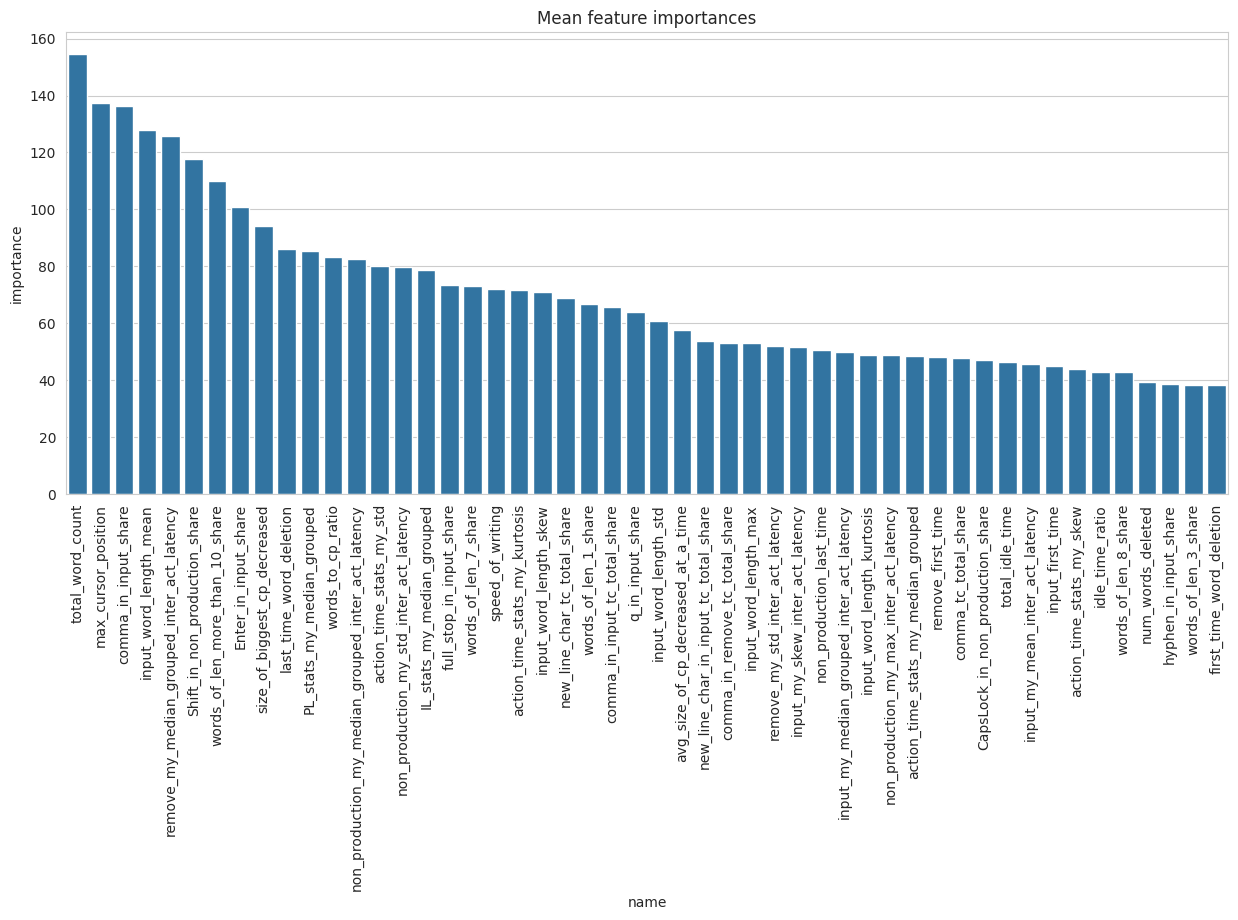

In [54]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df, x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Evaluation of OOF Preds on Training Set (CV)

In [55]:
for fold in range(cnfg.num_folds):
    print(f"Predicting the train set with FOLD {fold}")
    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][cnfg.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][cnfg.response_variate]

    lgb_model = models_dict[fold]
    pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
    train_feats.loc[X_val.index, f"pred_{cnfg.response_variate}"] = pred_val

Predicting the train set with FOLD 0
Predicting the train set with FOLD 1
Predicting the train set with FOLD 2
Predicting the train set with FOLD 3
Predicting the train set with FOLD 4


In [56]:
rmse = mean_squared_error(
    train_feats[cnfg.response_variate],
    np.clip(train_feats[f"pred_{cnfg.response_variate}"], a_min=0.5, a_max=6.0),
    squared=False,
)
print("CV RMSE:", rmse)
train_feats = train_feats.drop(columns=["pred_score"])

CV RMSE: 0.6352823798728754


# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [43]:
for fold in range(cnfg.num_folds):
    print(f"Predicting the test set with FOLD {fold}")
    X_test = test_feats[feature_names]

    lgb_model = models_dict[fold]
    pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
    test_feats[f"pred_{cnfg.response_variate}_fold{fold}"] = pred

test_feats[cnfg.response_variate] = test_feats[
    [f"pred_{cnfg.response_variate}_fold{fold}" for fold in range(cnfg.num_folds)]
].mean(axis=1)
test_feats[cnfg.response_variate] = np.clip(
    test_feats[cnfg.response_variate], a_min=0.5, a_max=6.0
)

Predicting the test set with FOLD 0
Predicting the test set with FOLD 1
Predicting the test set with FOLD 2
Predicting the test set with FOLD 3
Predicting the test set with FOLD 4


# Submission

In [44]:
submission = test_feats[["id", cnfg.response_variate]]
submission

,id,score
0,0000aaaa,1.627326
1,2222bbbb,1.685968
2,4444cccc,1.657229


In [45]:
submission.to_csv("submission.csv", index=False)